A notebook which contains an evaluation of the SalishSeaCast model within PugetSound. More specifically, it compares observed data on various nutrient concentrations collected from bottle data and compares it to model outputs. It also looks at temperature and salinity data collected from CTD data and compares model error to these environmental variables. This evaluation includes scatter plots and 2d histograms visualizing the similarity of observed and model data as well as tables of evaluation statistics.

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib as mpl
import scipy.interpolate as sinterp
import pickle
import Keegan_eval_tools as ket
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
years=[2009,2010]
year=2010
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/kflanaga/MEOPAR/savedData/WADE_nutribot_pickles'

In [4]:
# Parameters
years = [2015, 2016]
year = 2016
modver = "nowcast-green.201905"
PATH = "/results2/SalishSea/nowcast-green.201905/"
datadir = "/ocean/kflanaga/MEOPAR/savedData/WADE_nutribot_pickles"


In [5]:
display(Markdown('''## Year: ''' + str(year)))

## Year: 2016

In [6]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

## Yearly model-data comparisons of nutrients, chlorophyll, temperature and salinity between 201905 runs and WADE observations

In [7]:
##### Loading in pickle file data
with open(os.path.join(datadir,f'data_WADE_{modelversion}_{years[0]}.pkl'),'rb') as hh:
    data_year1=pickle.load(hh)
with open(os.path.join(datadir,f'data_WADE_{modelversion}_{years[1]}.pkl'),'rb') as hh:
    data_year2=pickle.load(hh)
    
data_all=pd.concat((data_year1,data_year2),ignore_index=True)

In [8]:
# Creating seperate dataframes for each season (includes only data above 15 metre depth.)
iz=(data_all.Z<15)
DJF=data_all.loc[iz&(data_all.dtUTC>=dt.datetime(years[0],12,1))&(data_all.dtUTC<=dt.datetime(years[1],3,1)),:]
MAM=data_all.loc[iz&(data_all.dtUTC<=dt.datetime(years[1],6,1))&(data_all.dtUTC>dt.datetime(years[1],3,1)),:]
JJA=data_all.loc[iz&(data_all.dtUTC<=dt.datetime(years[1],9,1))&(data_all.dtUTC>dt.datetime(years[1],6,1)),:]
SON=data_all.loc[iz&(data_all.dtUTC>dt.datetime(years[1],9,1))&(data_all.dtUTC<=dt.datetime(years[1],11,30)),:]

In [9]:
data=data_all.loc[(data_all.dtUTC>=dt.datetime(years[0],12,1))&(data_all.dtUTC<=dt.datetime(years[1],11,30)),:]

In [10]:
datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]
    
datreg=dict()
for iregion in data.Basin.unique():
    datreg[iregion] = data.loc[data.Basin==iregion]   

In [11]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, DJF':DJF,
                      'z < 15 m, MAM':MAM,
                      'z < 15 m, JJA':JJA,
                      'z < 15 m, SON': SON,})
for iregion in data.Basin.unique():
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, DJF', 'z < 15 m, MAM', 'z < 15 m, JJA', 'z < 15 m, SON', 'Hood Canal Basin', 'South Basin', 'Main Basin', 'Admiralty Inlet', 'Strait of Georgia', 'Whidbey Basin'])

## Map of observation locations in each basin

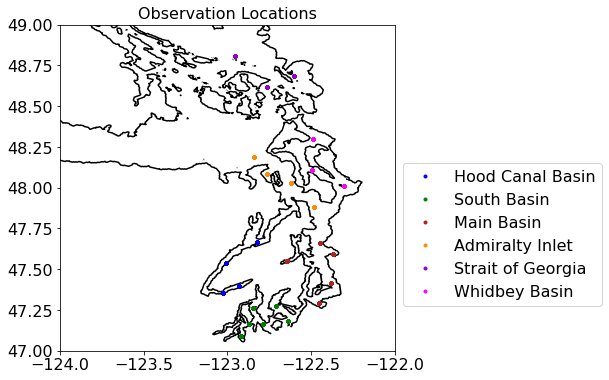

In [12]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
for ind, iregion in enumerate(data.Basin.unique()):
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

# Nitrate

### Table containing evaluation statistics for relevant subsets

In [13]:
# Defining variables needed for nitrate evaluations
obsvar='NO23'
modvar='mod_nitrate'

In [14]:
statsDict={year:dict()}
statsDict[year]['NO3']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['NO3'][isub]=dict()
    var=statsDict[year]['NO3'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['NO3'],level='Subset',suborder=list(statsubs.keys()))
tbl

z < 15 m
15 m < z < 22 m
z >= 22 m
z > 50 m
all
z < 15 m, DJF
z < 15 m, MAM
z < 15 m, JJA
z < 15 m, SON
Hood Canal Basin
South Basin
Main Basin
Admiralty Inlet
Strait of Georgia
Whidbey Basin


### Model vs Observed comparisons by depth and region

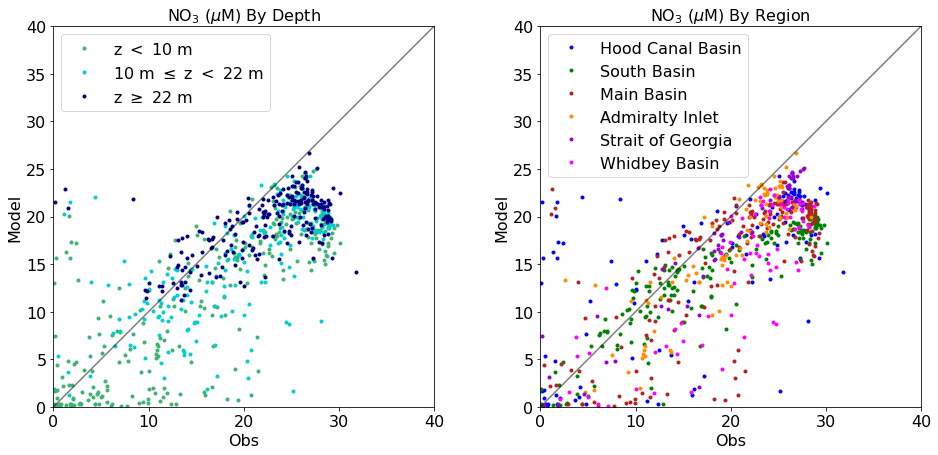

In [15]:
lims=(0,40)

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,lims,depth_range=(10,22))
ax[0].set_title('NO$_3$ ($\mu$M) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,lims)
ax[1].set_title('NO$_3$ ($\mu$M) By Region');

### Model vs Observed comparisons for individual seasons

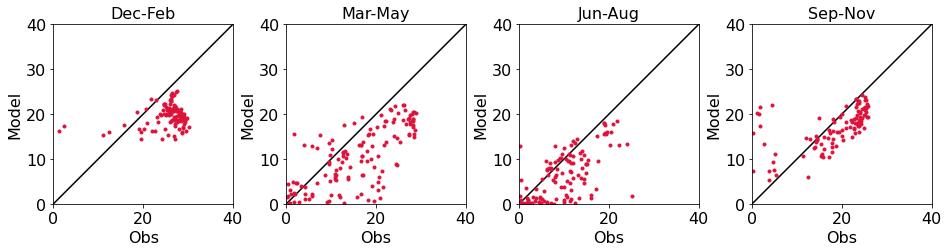

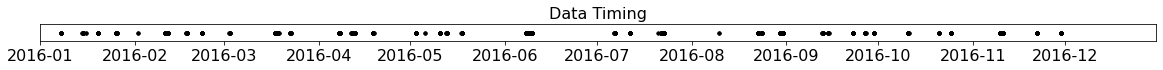

In [16]:
seasons=[DJF,MAM,JJA,SON]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
ket.bySeason(ax,seasons,obsvar,modvar,lims,season_titles)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Model vs Observed comparisons for individual regions and stations

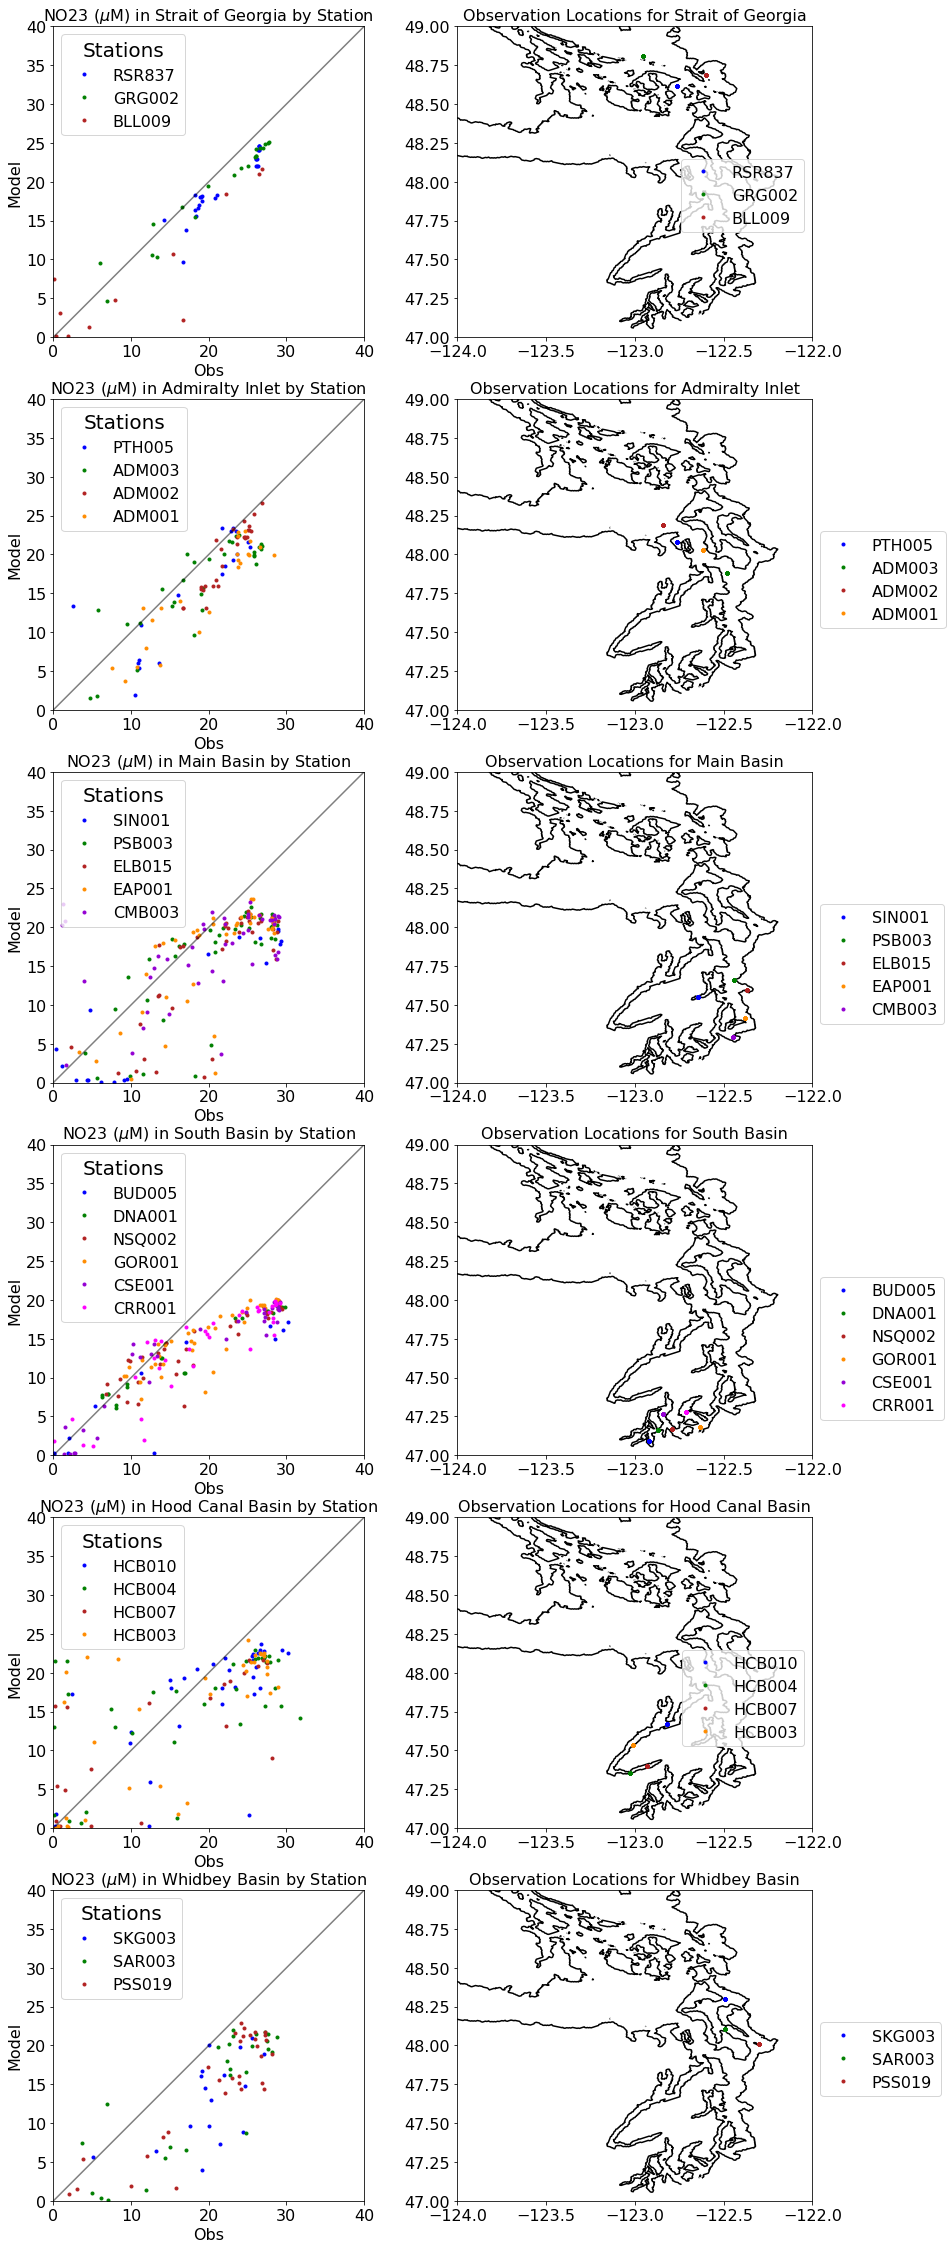

In [17]:
obsvar='NO23'
modvar='mod_nitrate'
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ax=ket.multi_station_graph(data,datstat,obsvar,modvar,regions,lims)

# Dissolved Silica

### Table containing evaluation statistics for relevant subsets

In [18]:
# Defining Variables needed for silica determination 
obsvar='Si'
modvar='mod_silicon'

In [19]:
statsDict[year]['dSi']=OrderedDict()
for isub in statsubs:
    statsDict[year]['dSi'][isub]=dict()
    var=statsDict[year]['dSi'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['dSi'],level='Subset',suborder=list(statsubs.keys()))
tbl

### Model vs Observed comparisons by depth and region

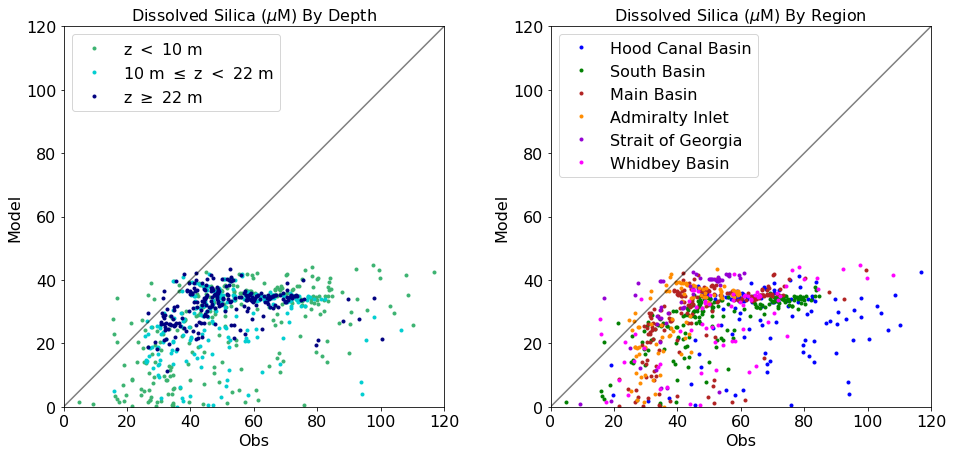

In [20]:
lims=(0,120)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,lims,depth_range=(10,22))
ax[0].set_title('Dissolved Silica ($\mu$M) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,lims)
ax[1].set_title('Dissolved Silica ($\mu$M) By Region');

### Model vs Observed comparisons for individual seasons

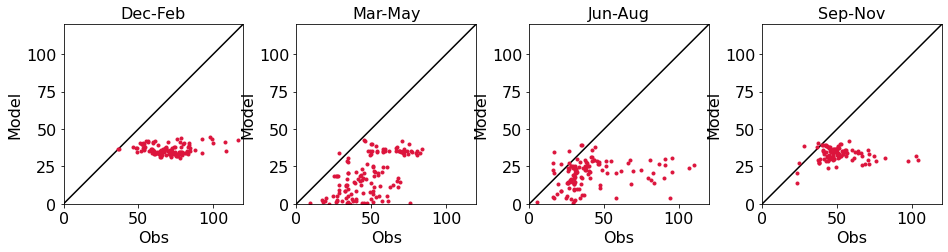

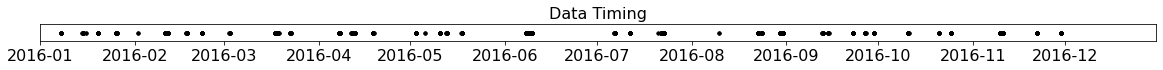

In [21]:
seasons=[DJF,MAM,JJA,SON]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
ket.bySeason(ax,seasons,obsvar,modvar,lims,season_titles)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Model vs Observed comparisons for individual regions and stations

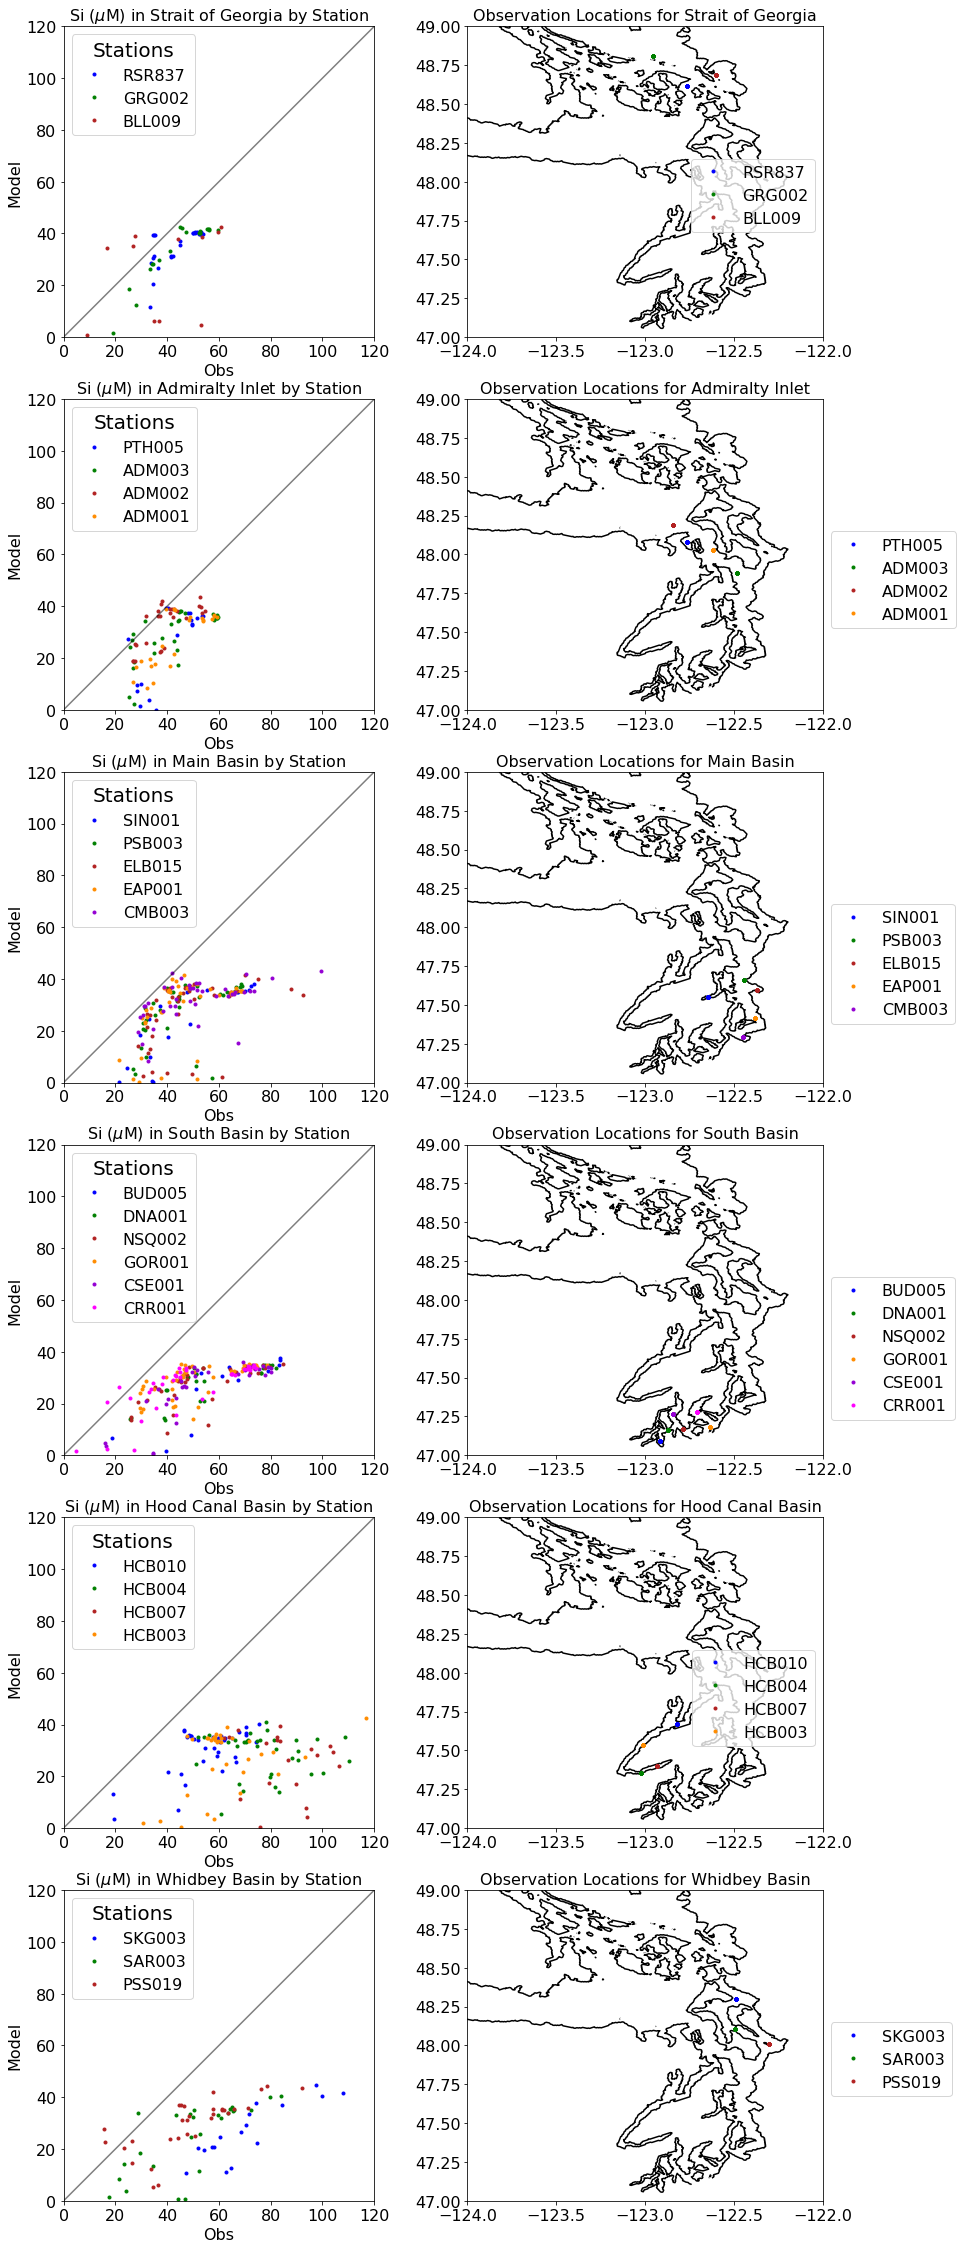

In [22]:
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ax=ket.multi_station_graph(data,datstat,obsvar,modvar,regions,lims)

### Profiles of NO3 and Dissolved Silica

Text(0.5, 1.0, 'dSi')

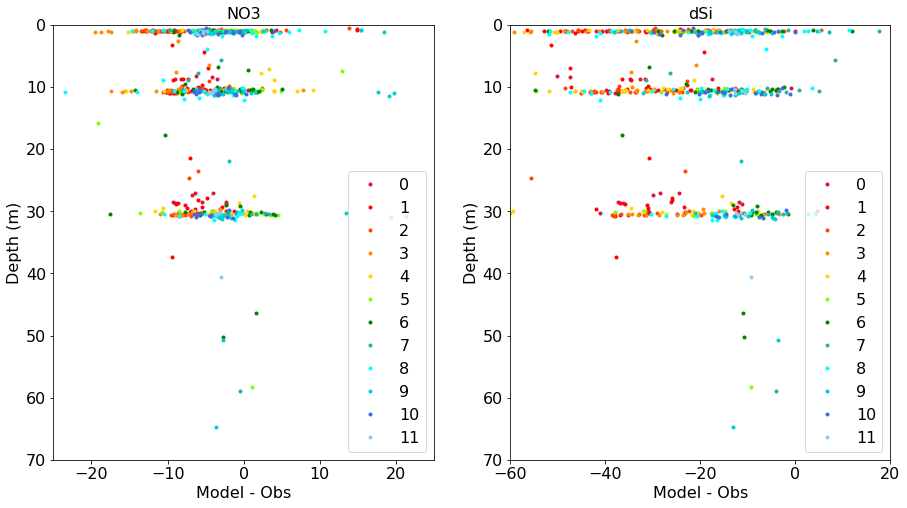

In [23]:
start_date = dt.datetime(year,1,1)
end_date = dt.datetime(year,12,31)

fig, ax = plt.subplots(1,2,figsize = (15,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'darkturquoise','royalblue','lightskyblue','blue','darkblue','mediumslateblue','blueviolet',
      'darkmagenta','fuchsia','deeppink','pink')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['NO23']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(70,0)
    axi.set_ylabel('Depth (m)')
ax[0].set_xlabel('Model - Obs')
ax[1].set_xlabel('Model - Obs')
ax[0].set_xlim(-25,25)
ax[1].set_xlim(-60,20)
ax[0].set_title('NO3')
ax[1].set_title('dSi')

# dSi:NO3 Ratios

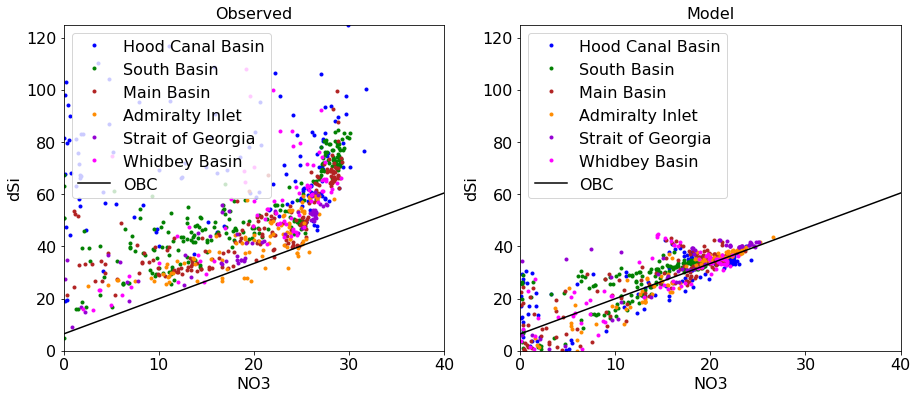

In [24]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
for ind,iregion in enumerate(data.Basin.unique()):
    p1=ax[0].plot(datreg[iregion]['NO23'],datreg[iregion]['Si'],'.',
                  color=colors[ind],label=iregion)
ax[0].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')  
ax[0].set_title('Observed')
ax[0].set_xlabel('NO3')
ax[0].set_ylabel('dSi')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,125)
ax[0].legend()

for ind,iregion in enumerate(data.Basin.unique()):
    p=ax[1].plot(datreg[iregion]['mod_nitrate'],datreg[iregion]['mod_silicon'],'.',  
                  color=colors[ind],label=iregion)
ax[1].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[1].set_title('Model')
ax[1].set_xlabel('NO3')
ax[1].set_ylabel('dSi')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,125)
ax[1].legend()
#ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
#ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

# NH4

### Table containing evaluation statistics for relevant subsets

In [25]:
# Defining Variables for determining Ammonium
obsvar='Amm'
modvar='mod_ammonium'
seasons=[DJF,MAM,JJA,SON]

In [26]:
statsDict[year]['NH4']=OrderedDict()
for isub in statsubs:
    statsDict[year]['NH4'][isub]=dict()
    var=statsDict[year]['NH4'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['NH4'],level='Subset',suborder=list(statsubs.keys()))
tbl

### Model vs Observed comparisons by depth and region

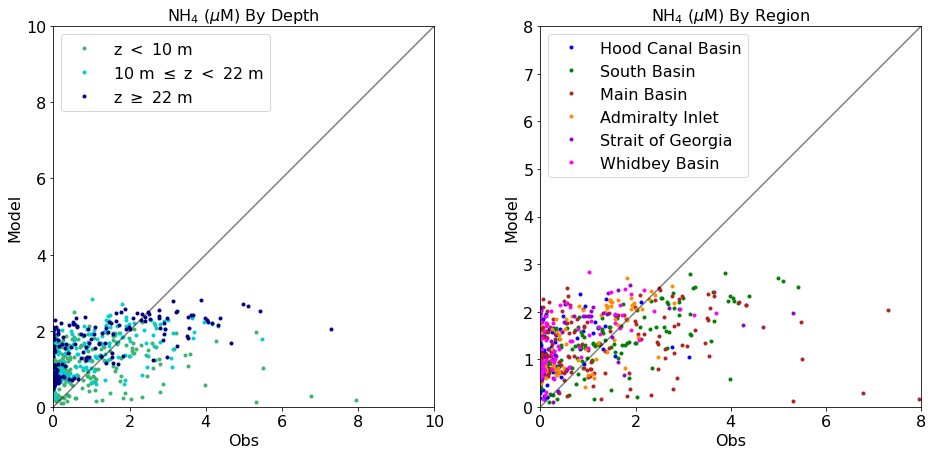

In [27]:
lims=(0,10)

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,lims,depth_range=(10,22))
ax[0].set_title('NH$_4$ ($\mu$M) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,(0,8))
ax[1].set_title('NH$_4$ ($\mu$M) By Region');

### Model vs Observed comparisons for individual seasons

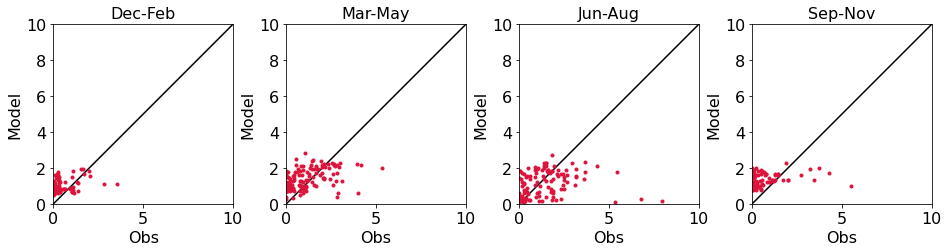

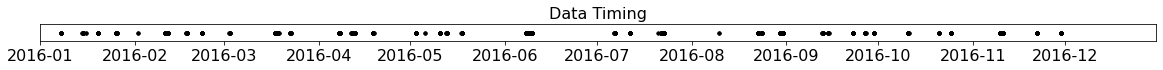

In [28]:
seasons=[DJF,MAM,JJA,SON]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
ket.bySeason(ax,seasons,obsvar,modvar,lims,season_titles)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Model vs Observed comparisons for individual regions and stations

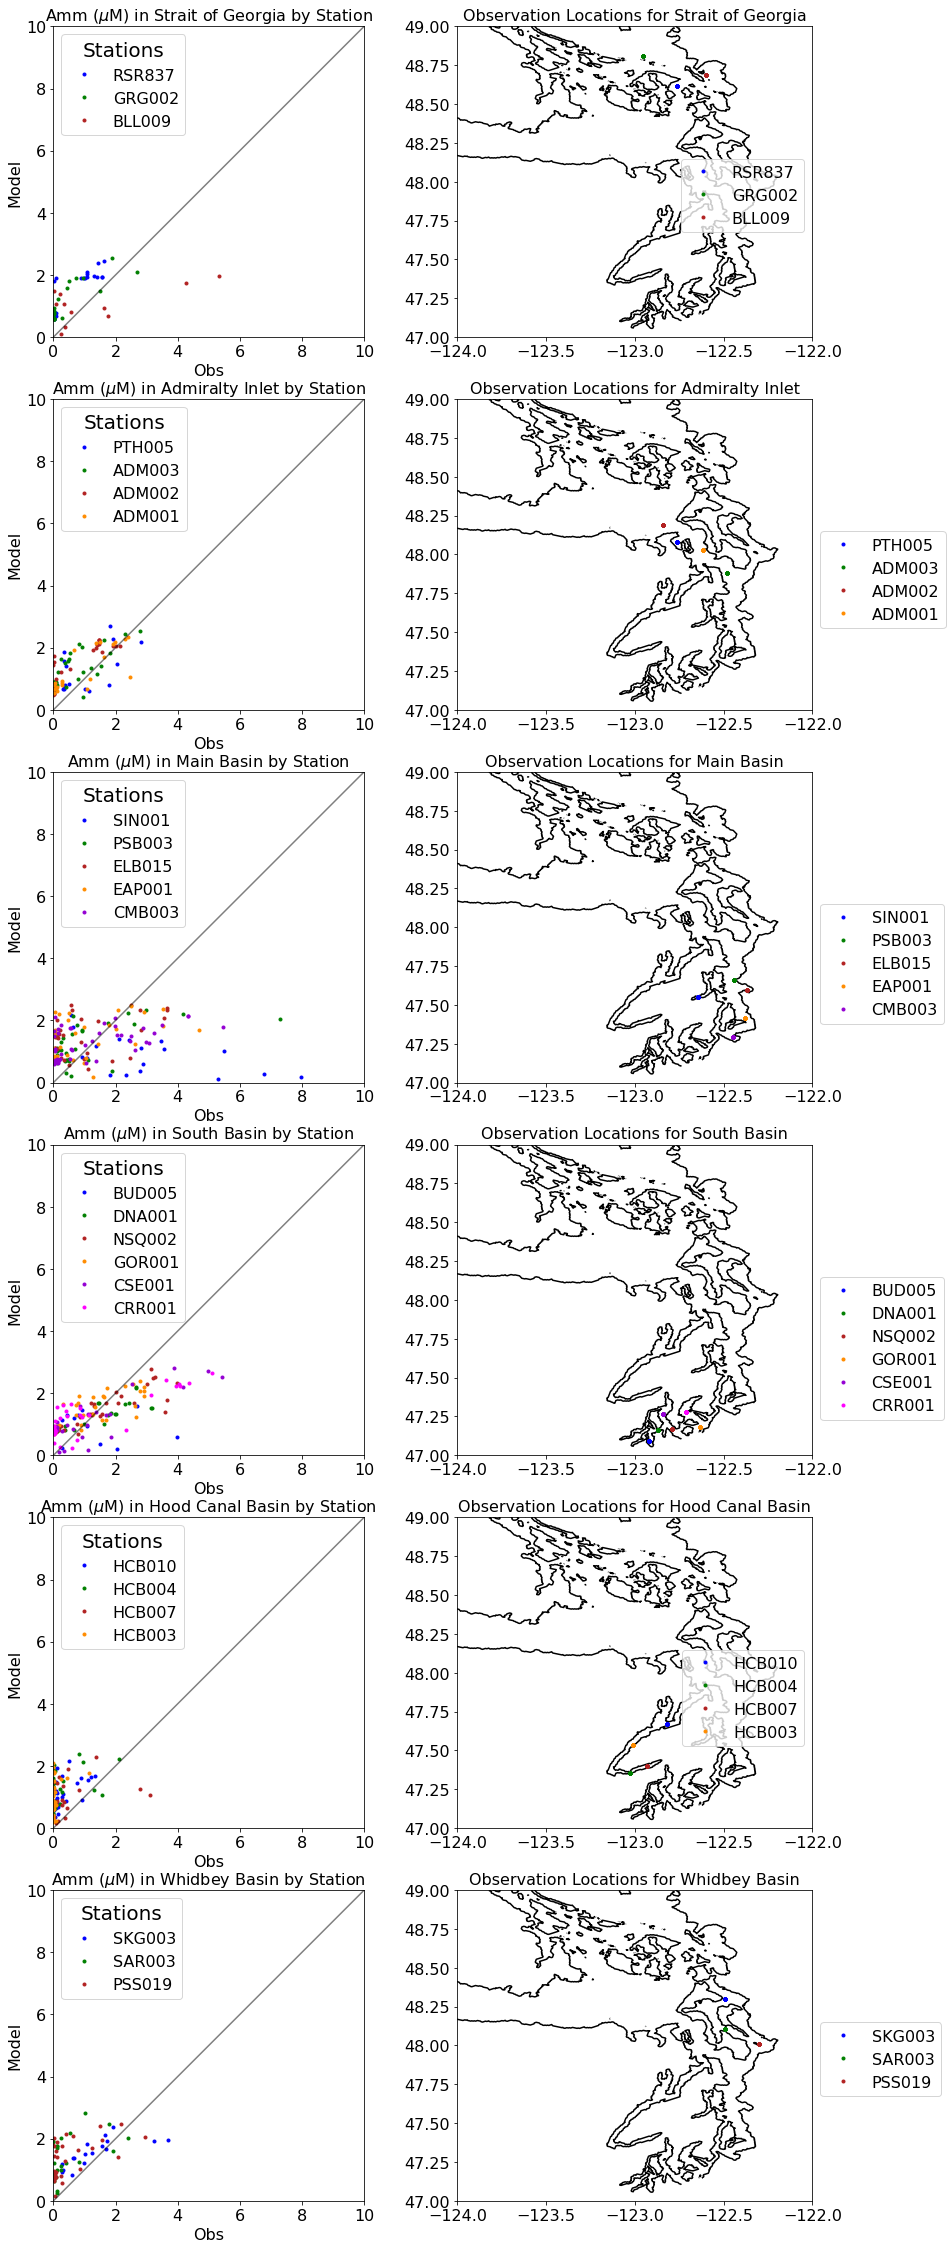

In [29]:
obsvar='Amm'
modvar='mod_ammonium'
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ax=ket.multi_station_graph(data,datstat,obsvar,modvar,regions,lims)

# Model Error vs Observed Environmental Variables

In [30]:
### These groupings will be used to calculate correlation statistics. The keys are labels and
### the values are corresponding dataframe views
errsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                     'z > 15 m':data.loc[data.Z>15],
                     'all':data,})

### An empty nested dictionary which the correlation statistics will be organized into.
ErrDict={'CT':dict(),
        'SA':dict(),
        'Lat':dict()}

In [31]:
def scatter_err(ax,fig,df,envvar,modvar,obsvar):
    m=ax.scatter(df[envvar],df[modvar]-df[obsvar],c=df['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)',shrink=0.8)
    ax.set_ylabel('Modeled')
    ax.set_xlabel('Observed')
    plt.tight_layout()
    return ps

## Error vs temperature

### Table containing evaluation statistics for relevant subsets

In [32]:
envvar='CT'
obsvars=['NO23','Si','Amm']
modvars=['mod_nitrate','mod_silicon','mod_ammonium']

for obsvar, modvar in zip(obsvars,modvars):
    ErrDict[envvar][obsvar]=OrderedDict()
    for isub in errsubs:
        ErrDict[envvar][obsvar][isub]=dict()
        var=ErrDict[envvar][obsvar][isub]
        var['R$^2$'],var['P Value']=ket.err_corr_stats(errsubs[isub].loc[:,[envvar]],
                                                        errsubs[isub].loc[:,[obsvar]],
                                                        errsubs[isub].loc[:,[modvar]])
tbl,tdf=ket.Display_CorrStats(ErrDict[envvar],level='Variable')
tbl

### Correlation plots of error vs temperature for different depths

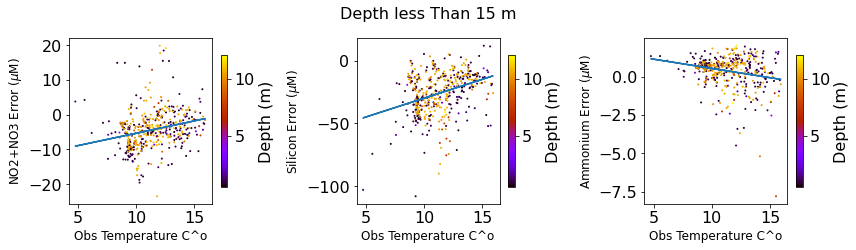

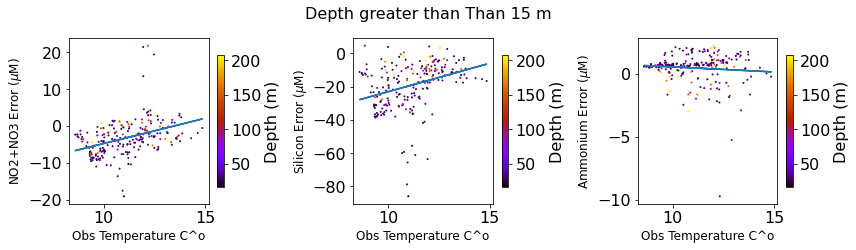

In [33]:
fig,ax=plt.subplots(1,3,figsize=(12,3.5))
fig.subplots_adjust(wspace=.6)

for ind,obsvar,modvar in zip(range(3),obsvars,modvars):
    scatter_err(ax[ind],fig,data[(data.Z <15)&(data.CT >4)&(data.CT < 16)],envvar,modvar,obsvar)
    ket.err_corr_plot(ax[ind],data[(data.Z <15)&(data.CT >4)&(data.CT < 16)],modvar,obsvar,envvar)

ax[0].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)
ax[1].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[1].set_ylabel('Silicon Error ($\mu$M)',fontsize=12)
ax[2].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[2].set_ylabel('Ammonium Error ($\mu$M)',fontsize=12)
fig.suptitle('Depth less Than 15 m')
plt.tight_layout()

fig,ax=plt.subplots(1,3,figsize=(12,3.5))
fig.subplots_adjust(wspace=.6)

for ind,obsvar,modvar in zip(range(3),obsvars,modvars):
    scatter_err(ax[ind],fig,data[(data.Z > 15)&(data.CT > 4)&(data.CT < 16)],envvar,modvar,obsvar)
    ket.err_corr_plot(ax[ind],data[(data.Z > 15)&(data.CT > 4)&(data.CT < 16)],modvar,obsvar,envvar)

ax[0].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)
ax[1].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[1].set_ylabel('Silicon Error ($\mu$M)',fontsize=12)
ax[2].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[2].set_ylabel('Ammonium Error ($\mu$M)',fontsize=12)
fig.suptitle('Depth greater than Than 15 m')
plt.tight_layout()

## Error vs salinity

### Table containing evaluation statistics for relevant subsets

In [34]:
envvar='SA'
obsvars=['NO23','Si','Amm']
modvars=['mod_nitrate','mod_silicon','mod_ammonium']

for obsvar, modvar in zip(obsvars,modvars):
    ErrDict[envvar][obsvar]=OrderedDict()
    for isub in errsubs:
        ErrDict[envvar][obsvar][isub]=dict()
        var=ErrDict[envvar][obsvar][isub]
        var['R$^2$'],var['P Value']=ket.err_corr_stats(errsubs[isub].loc[:,[envvar]],
                                                        errsubs[isub].loc[:,[obsvar]],
                                                        errsubs[isub].loc[:,[modvar]])
tbl,tdf=ket.Display_CorrStats(ErrDict[envvar],level='Variable')
tbl

### Correlation plots of error vs salinity

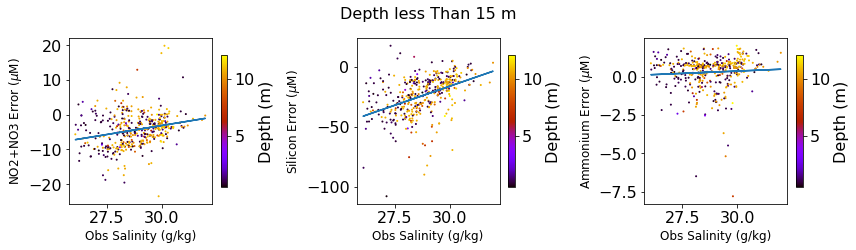

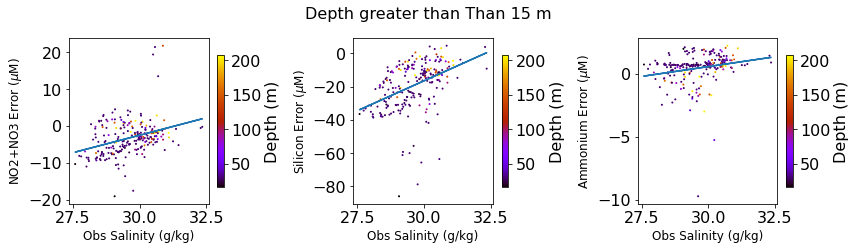

In [35]:
fig,ax=plt.subplots(1,3,figsize=(12,3.5))
fig.subplots_adjust(wspace=.6)

for ind,obsvar,modvar in zip(range(3),obsvars,modvars):
    scatter_err(ax[ind],fig,data[(data.Z < 15)&(data.SA >26)&(data.SA < 33)],envvar,modvar,obsvar)
    ket.err_corr_plot(ax[ind],data[(data.Z < 15)&(data.SA >26)&(data.SA < 33)],modvar,obsvar,envvar)

ax[0].set_xlabel('Obs Salinity (g/kg)',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)
ax[1].set_xlabel('Obs Salinity (g/kg)',fontsize=12)
ax[1].set_ylabel('Silicon Error ($\mu$M)',fontsize=12)
ax[2].set_xlabel('Obs Salinity (g/kg)',fontsize=12)
ax[2].set_ylabel('Ammonium Error ($\mu$M)',fontsize=12)
fig.suptitle('Depth less Than 15 m')
plt.tight_layout()

fig,ax=plt.subplots(1,3,figsize=(12,3.5))
fig.subplots_adjust(wspace=.6)

for ind,obsvar,modvar in zip(range(3),obsvars,modvars):
    scatter_err(ax[ind],fig,data[(data.Z > 15)&(data.SA >26)&(data.SA < 33)],envvar,modvar,obsvar)
    ket.err_corr_plot(ax[ind],data[(data.Z > 15)&(data.SA >26)&(data.SA < 33)],modvar,obsvar,envvar)

ax[0].set_xlabel('Obs Salinity (g/kg)',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)
ax[1].set_xlabel('Obs Salinity (g/kg)',fontsize=12)
ax[1].set_ylabel('Silicon Error ($\mu$M)',fontsize=12)
ax[2].set_xlabel('Obs Salinity (g/kg)',fontsize=12)
ax[2].set_ylabel('Ammonium Error ($\mu$M)',fontsize=12)
fig.suptitle('Depth greater than Than 15 m')
plt.tight_layout()

## Error vs lat

### Table containing evaluation statistics for relevant subsets

In [36]:
envvar='Lat'
obsvars=['NO23','Si','Amm']
modvars=['mod_nitrate','mod_silicon','mod_ammonium']

for obsvar, modvar in zip(obsvars,modvars):
    ErrDict[envvar][obsvar]=OrderedDict()
    for isub in errsubs:
        ErrDict[envvar][obsvar][isub]=dict()
        var=ErrDict[envvar][obsvar][isub]
        var['R$^2$'],var['P Value']=ket.err_corr_stats(errsubs[isub].loc[:,[envvar]],
                                                        errsubs[isub].loc[:,[obsvar]],
                                                        errsubs[isub].loc[:,[modvar]])
tbl,tdf=ket.Display_CorrStats(ErrDict[envvar],level='Variable')
tbl

### Correlation plots of error vs latitude for different depths

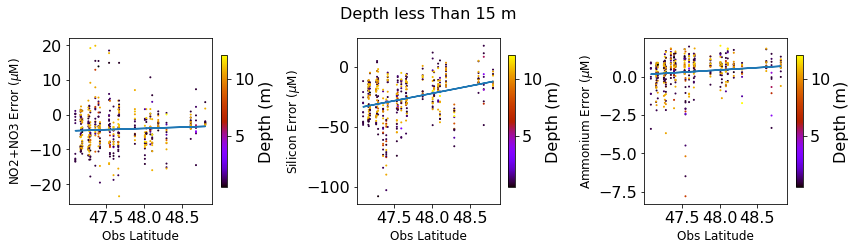

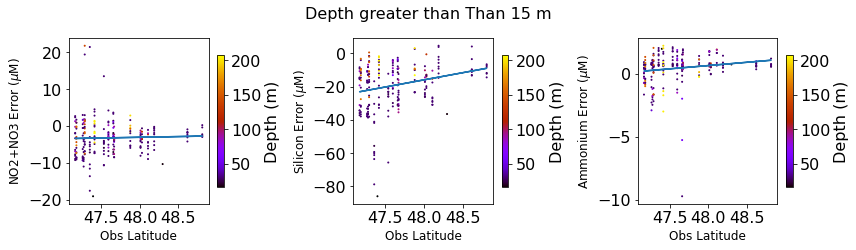

In [37]:
fig,ax=plt.subplots(1,3,figsize=(12,3.5))
fig.subplots_adjust(wspace=.6)

for ind,obsvar,modvar in zip(range(3),obsvars,modvars):
    scatter_err(ax[ind],fig,data[(data.Z < 15)],envvar,modvar,obsvar)
    ket.err_corr_plot(ax[ind],data[(data.Z < 15)],modvar,obsvar,envvar)

ax[0].set_xlabel('Obs Latitude',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)
ax[1].set_xlabel('Obs Latitude',fontsize=12)
ax[1].set_ylabel('Silicon Error ($\mu$M)',fontsize=12)
ax[2].set_xlabel('Obs Latitude',fontsize=12)
ax[2].set_ylabel('Ammonium Error ($\mu$M)',fontsize=12)
fig.suptitle('Depth less Than 15 m')
plt.tight_layout()

fig,ax=plt.subplots(1,3,figsize=(12,3.5))
fig.subplots_adjust(wspace=.6)

for ind,obsvar,modvar in zip(range(3),obsvars,modvars):
    scatter_err(ax[ind],fig,data[(data.Z > 15)],envvar,modvar,obsvar)
    ket.err_corr_plot(ax[ind],data[(data.Z > 15)],modvar,obsvar,envvar)

ax[0].set_xlabel('Obs Latitude',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)
ax[1].set_xlabel('Obs Latitude',fontsize=12)
ax[1].set_ylabel('Silicon Error ($\mu$M)',fontsize=12)
ax[2].set_xlabel('Obs Latitude',fontsize=12)
ax[2].set_ylabel('Ammonium Error ($\mu$M)',fontsize=12)
fig.suptitle('Depth greater than Than 15 m')
plt.tight_layout()

## Summary Table of Correlation Statistics

In [38]:
tbl,tdf=ket.Display_CorrStats(ErrDict,level='Environmental Variable')
tbl

## Error vs salinity error

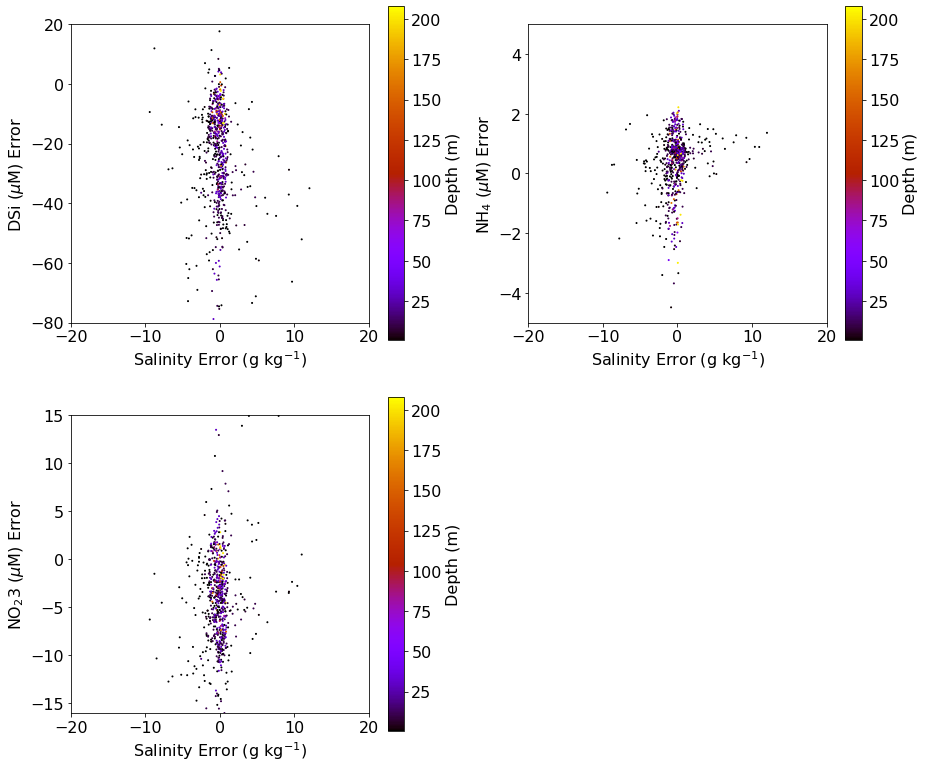

In [39]:
fig,ax=plt.subplots(2,2,figsize=(13,11))
ax[0][0].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[0][0].set_ylabel('DSi ($\mu$M) Error')
m,cb=ket.ErrErr(data,fig,ax[0][0],'SA','mod_vosaline','Si','mod_silicon',(-20,20),(-80,20))
ax[0][1].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[0][1].set_ylabel('NH$_4$ ($\mu$M) Error')
m,cb=ket.ErrErr(data,fig,ax[0][1],'SA','mod_vosaline','Amm','mod_ammonium',(-20,20),(-5,5))
ax[1][0].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[1][0].set_ylabel('NO$_23$ ($\mu$M) Error')
m,cb=ket.ErrErr(data,fig,ax[1][0],'SA','mod_vosaline','NO23','mod_nitrate',(-20,20),(-16,15))
fig.delaxes(ax[-1][-1])
plt.tight_layout()

# CTD Environmental data.
The following sections contain model-data comparisons for temperature and salinity collected using CTD. These comparisons represent a limited subset of the total CTD data that was sampled at the same depth and time as the nutrient bottle data. An analysis of the complete CTD datasets can be found in Individual_year_CTD_evaluations. 
# Salinity

### Table containing evaluation statistics for relevant subsets

In [40]:
# Defining Variables for determining Ammonium
obsvar='SA'
modvar='mod_vosaline'
seasons=[DJF,MAM,JJA,SON]

In [41]:
statsDict[year][obsvar]=OrderedDict()
for isub in statsubs:
    statsDict[year][obsvar][isub]=dict()
    var=statsDict[year][obsvar][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year][obsvar],level='Subset',suborder=list(statsubs.keys()))
tbl

### Model vs Observed comparisons by depth and region

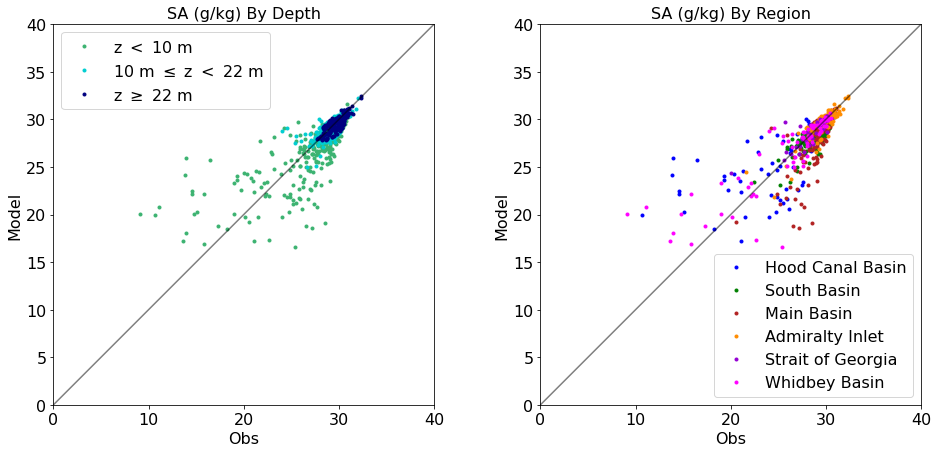

In [42]:
lims=(0,40)

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,lims,depth_range=(10,22))
ax[0].set_title('SA (g/kg) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,lims)
ax[1].set_title('SA (g/kg) By Region');

### Model vs Observed comparisons for individual seasons

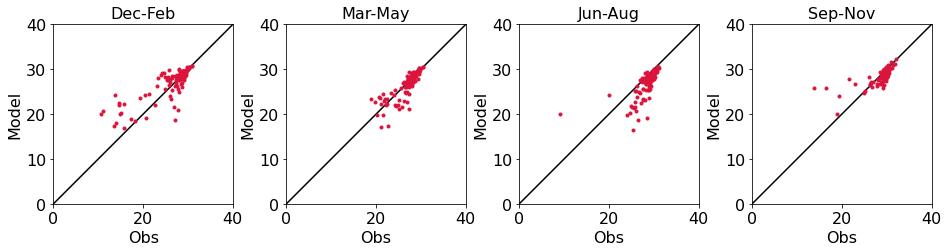

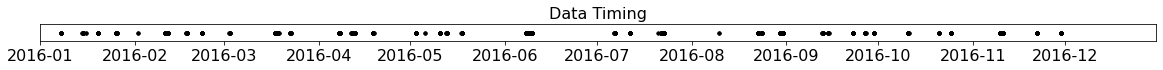

In [43]:
seasons=[DJF,MAM,JJA,SON]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
ket.bySeason(ax,seasons,obsvar,modvar,lims,season_titles)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Model vs Observed comparisons for individual regions and stations

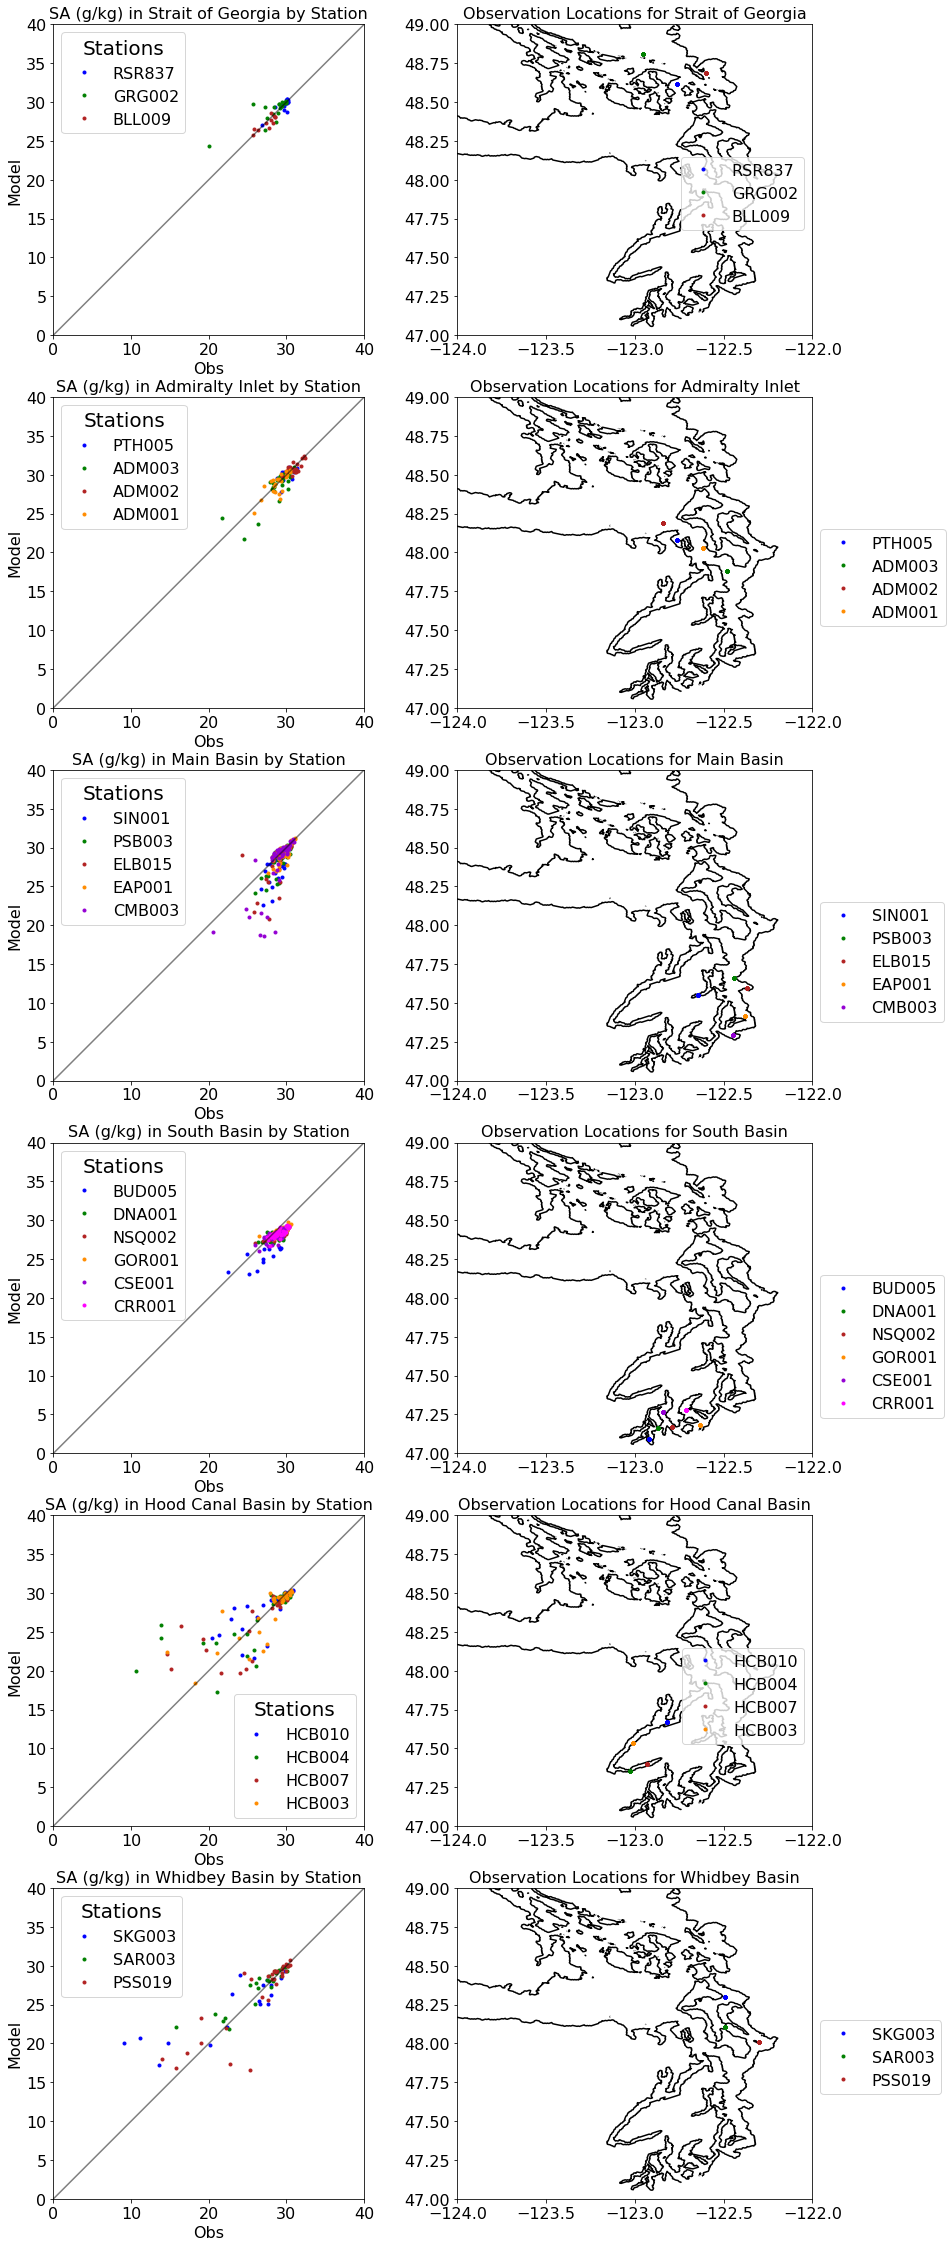

In [44]:
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ax=ket.multi_station_graph(data,datstat,obsvar,modvar,regions,lims,units='(g/kg)')

# Temperature

### Table containing evaluation statistics for relevant subsets

In [45]:
# Defining Variables for determining Ammonium
obsvar='CT'
modvar='mod_votemper'
seasons=[DJF,MAM,JJA,SON]

In [46]:
statsDict[year][obsvar]=OrderedDict()
for isub in statsubs:
    statsDict[year][obsvar][isub]=dict()
    var=statsDict[year][obsvar][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year][obsvar],level='Subset',suborder=list(statsubs.keys()))
tbl

### Model vs Observed comparisons by depth and region

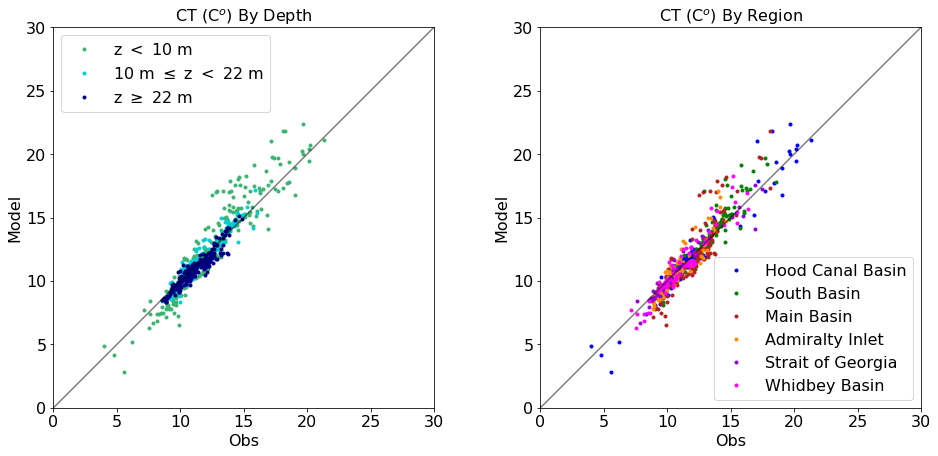

In [47]:
lims=(0,30)

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,lims,depth_range=(10,22))
ax[0].set_title('CT (C$^o$) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,lims)
ax[1].set_title('CT (C$^o$) By Region');

### Model vs Observed comparisons for individual seasons

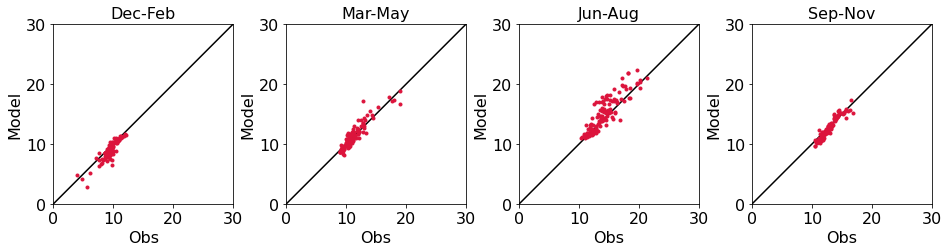

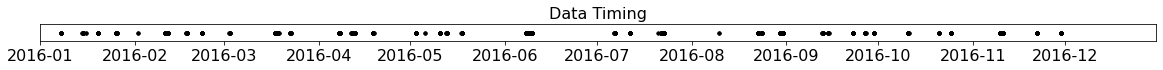

In [48]:
seasons=[DJF,MAM,JJA,SON]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
ket.bySeason(ax,seasons,obsvar,modvar,lims,season_titles)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Model vs Observed comparisons for individual regions and stations

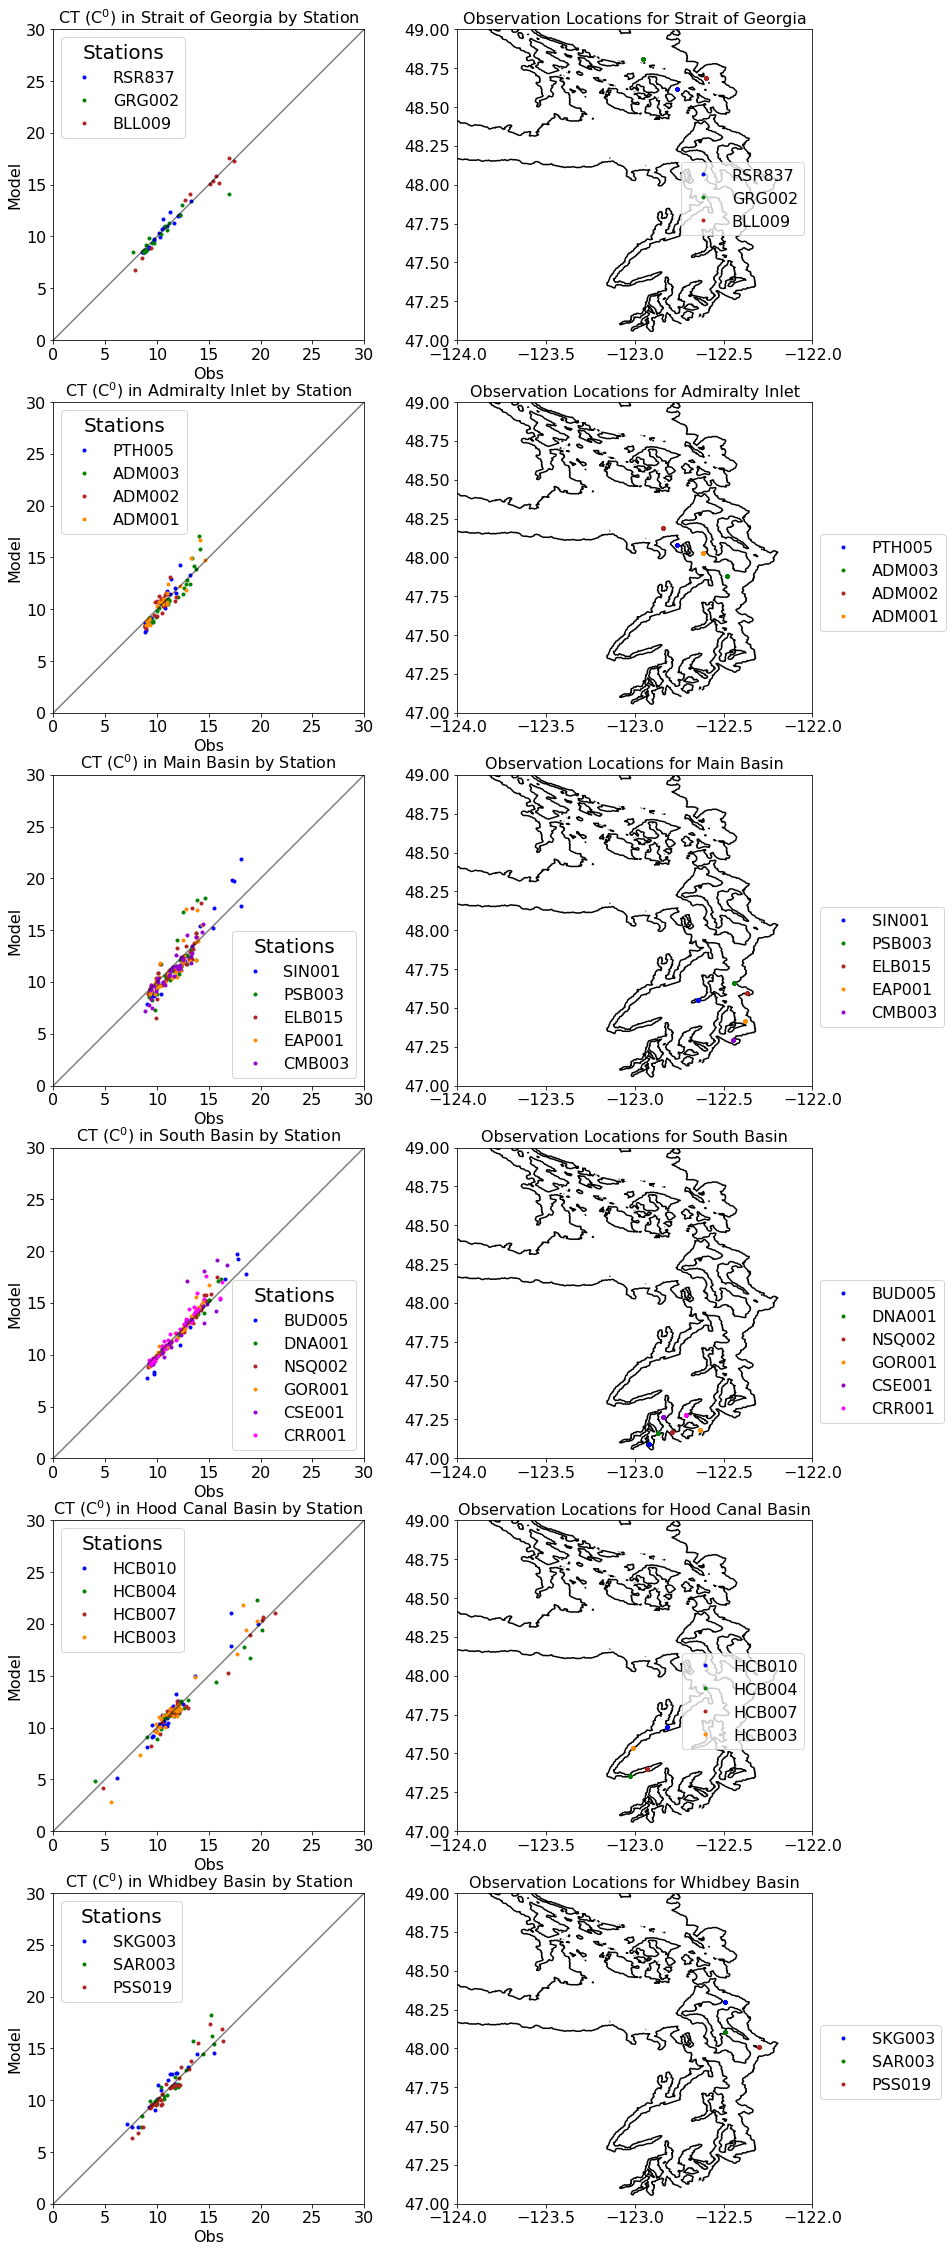

In [49]:
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ax=ket.multi_station_graph(data,datstat,obsvar,modvar,regions,lims,units='(C$^0$)')